In [1]:
# generic imports
import math
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from random import randrange

# torch imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [2]:
# Get galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  # reject some we don't care about, keep the rest
  (milkywaylikes_idx,) = np.where(labels > 3)
  images = np.array(F['images'][milkywaylikes_idx])
  # Milky way similar galaxies are class '3' ('-4' normalizes the labels again)
  labels = np.array(F['ans'][milkywaylikes_idx]) - 4

images = images.astype(np.float32) / 255.

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)    
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=32, cropy=32)

In [3]:
class GalaxgyDataset(torch.utils.data.Dataset):
    '''Create Galaxgy Training Dataset'''

    def __init__(self, data=None):     
        self.data = data
        self.x, self.y = data[0], data[1]
    
    def __len__(self):
        return len(self.y)
    
    def getx(self):
        return self.x
    
    def gety(self):
        return self.y    
    
    def __getitem__(self, idx):
        return {"inputs": torch.FloatTensor(np.transpose(self.x[idx], (2,1,0))),
                "labels": torch.LongTensor([self.y[idx]])}

In [4]:
dataset = GalaxgyDataset((images, labels))

In [5]:
batch_size = 512
num_workers = 8
device_ids = [0]

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 3 # Galaxgy images are RGB
latent_dim = 16 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = nn.functional.relu(self.enc1(x))
        x = nn.functional.relu(self.enc2(x))
        x = nn.functional.relu(self.enc3(x))
        x = nn.functional.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = nn.functional.relu(self.dec1(z))
        x = nn.functional.relu(self.dec2(x))
        x = nn.functional.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var
    
model = ConvVAE().cuda()

In [10]:
# learning rate
lr = 1e-3
# number of iterations
num_epocs = 50
# create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
#criterion = nn.MSELoss()

# run the main training loop
total_step = len(dataloader)
for epoch in range(num_epocs):
    correct = 0
    total   = 0
    for i_batch, data in enumerate(dataloader):
        x = data["inputs"].cuda()

        optimizer.zero_grad()
        reconstruction, mu, logvar = model(x)
        bce_loss = criterion(reconstruction, x)
        KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = bce_loss + KL_loss
        loss.backward()
        optimizer.step()
        
        if (i_batch+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], reconstruction: {:.3f}, kl_loss {:.3f}'\
                   .format(epoch+1, num_epocs, i_batch+1, total_step, bce_loss.item(), KL_loss))         

Epoch [1/50], Step [10/10], reconstruction: 168193.984, kl_loss 6.966
Epoch [2/50], Step [10/10], reconstruction: 148070.172, kl_loss 743.276
Epoch [3/50], Step [10/10], reconstruction: 127395.430, kl_loss 253.096
Epoch [4/50], Step [10/10], reconstruction: 119087.656, kl_loss 532.485
Epoch [5/50], Step [10/10], reconstruction: 119184.125, kl_loss 644.217
Epoch [6/50], Step [10/10], reconstruction: 116230.336, kl_loss 1058.035
Epoch [7/50], Step [10/10], reconstruction: 112537.984, kl_loss 797.214
Epoch [8/50], Step [10/10], reconstruction: 114317.250, kl_loss 655.172
Epoch [9/50], Step [10/10], reconstruction: 111755.633, kl_loss 700.308
Epoch [10/50], Step [10/10], reconstruction: 112627.438, kl_loss 629.095
Epoch [11/50], Step [10/10], reconstruction: 112256.945, kl_loss 529.781
Epoch [12/50], Step [10/10], reconstruction: 110111.859, kl_loss 551.518
Epoch [13/50], Step [10/10], reconstruction: 107279.953, kl_loss 500.486
Epoch [14/50], Step [10/10], reconstruction: 108277.266, kl_l

In [30]:
image = dataset[0]["inputs"]
reco_image,_,_ = model(image.view(1, 3, 32, 32).cuda())
reco_image = reco_image.view(3, 32, 32).detach().cpu()

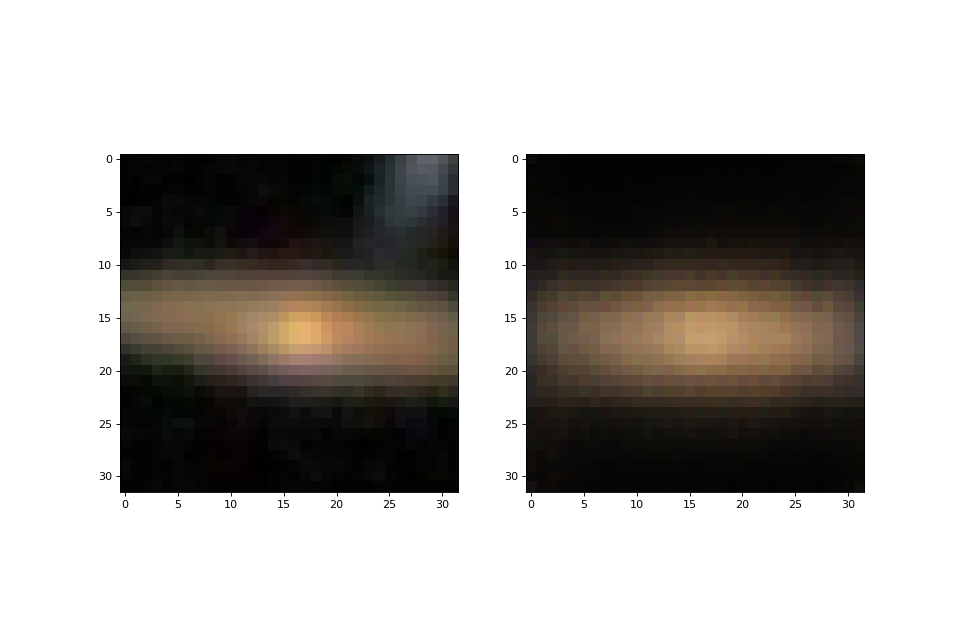

In [31]:
%matplotlib widget
fig = plt.figure(figsize=(12, 8), dpi=80)


plt.subplot(1, 2, 1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(reco_image.permute(1,2,0))